In [1]:
import numpy as np
import pandas as pd

import json
import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 6686 songs from data/tracks.json
First ten songs: [['002QT7AS6h1LAF5dla8D92', 'Still Smell Like It', 56], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 72], ['00B7TZ0Xawar6NZ00JFomN', 'Best Life (feat. Chance The Rapper)', 70], ['00Fboe8pNoWHLg1nn3e7Oi', 'Sands Of Time (Single Version) - Remastered', 0], ['00GL3XaK1sBpnB2eaam9SG', 'Ghost Town', 42], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 69], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 61], ['00Y9yFHumsN6Cg4cK3wXkM', 'Cap (feat. Trouble) - From Jxmtro', 51], ['00bWqt93aqLXqKtzZoq7Jw', 'MOOO!', 69], ['00ix2WCV1QGcrcVGliKJYY', 'Photograph - Felix Jaehn Remix', 28]]


## Data Exploration

/home/Sam/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


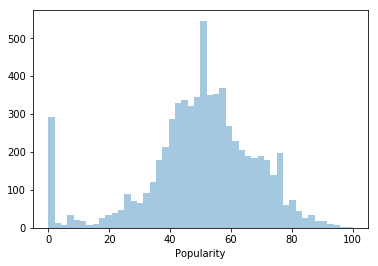

In [4]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [5]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['2LskIZrCeLxRvCiGP8gxlh', 'Arms Around You (feat. Maluma & Swae Lee)', 94],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 94],
 ['3ee8Jmje8o58CHK66QrVC2', 'SAD!', 94],
 ['4S8d14HvHb70ImctNgVzQQ', 'I Love It (& Lil Pump)', 94],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 95],
 ['5N5k9nd479b1xpDZ4usjrg', 'Promises (with Sam Smith)', 95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 96],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['2dpaYNEQHiRxtZbfNsse99', 'Happier', 98],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  100]]

## Feature Extraction

In [6]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'danceability': 0.83,
  'energy': 0.653,
  'key': 1,
  'loudness': -5.298,
  'mode': 1,
  'speechiness': 0.185,
  'acousticness': 0.0469,
  'instrumentalness': 0,
  'liveness': 0.112,
  'valence': 0.228,
  'tempo': 123.032,
  'type': 'audio_features',
  'id': '002QT7AS6h1LAF5dla8D92',
  'uri': 'spotify:track:002QT7AS6h1LAF5dla8D92',
  'track_href': 'https://api.spotify.com/v1/tracks/002QT7AS6h1LAF5dla8D92',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/002QT7AS6h1LAF5dla8D92',
  'duration_ms': 207827,
  'time_signature': 4}]

In [7]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [8]:
feats = features(songs)
feats[100]

{'danceability': 0.598,
 'energy': 0.559,
 'key': 4,
 'loudness': -7.534,
 'mode': 0,
 'speechiness': 0.0616,
 'acousticness': 0.301,
 'instrumentalness': 0,
 'liveness': 0.263,
 'valence': 0.0922,
 'tempo': 171.851,
 'type': 'audio_features',
 'id': '07VizkUweZe2lQo4yWIhgA',
 'uri': 'spotify:track:07VizkUweZe2lQo4yWIhgA',
 'track_href': 'https://api.spotify.com/v1/tracks/07VizkUweZe2lQo4yWIhgA',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/07VizkUweZe2lQo4yWIhgA',
 'duration_ms': 212482,
 'time_signature': 4,
 'name': "해장국 Hero's Soup",
 'popularity': 58}

In [9]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4610,0.8380,https://api.spotify.com/v1/audio-analysis/5O8i...,0.383,154773,0.460,5O8iyO7FjMWfUT0bppN0Gp,0.859000,10,0.134,-17.249,1,"The Well-Tempered Clavier, Book 1, Prelude & F...",21,0.0482,123.028,4,https://api.spotify.com/v1/tracks/5O8iyO7FjMWf...,audio_features,spotify:track:5O8iyO7FjMWfUT0bppN0Gp,0.530
62,0.0255,https://api.spotify.com/v1/audio-analysis/051A...,0.414,226467,0.783,051Adf71rDRL4QJnFw59UH,0.000000,9,0.329,-3.822,1,Never Been,38,0.3530,79.720,4,https://api.spotify.com/v1/tracks/051Adf71rDRL...,audio_features,spotify:track:051Adf71rDRL4QJnFw59UH,0.208
5109,0.5660,https://api.spotify.com/v1/audio-analysis/5zsv...,0.729,160049,0.760,5zsvsYTfODtoFlGI2KcEJi,0.000194,4,0.115,-5.590,0,Spooky,50,0.0273,106.904,4,https://api.spotify.com/v1/tracks/5zsvsYTfODto...,audio_features,spotify:track:5zsvsYTfODtoFlGI2KcEJi,0.462
5300,0.0231,https://api.spotify.com/v1/audio-analysis/6DMZ...,0.796,236095,0.596,6DMZ0fL01U2eZJ9N3HzgkV,0.000000,8,0.097,-6.541,1,Bail Out (feat. YoungBoy Never Broke Again),37,0.2220,148.058,4,https://api.spotify.com/v1/tracks/6DMZ0fL01U2e...,audio_features,spotify:track:6DMZ0fL01U2eZJ9N3HzgkV,0.729
2811,0.0123,https://api.spotify.com/v1/audio-analysis/3GGk...,0.546,182893,0.835,3GGkqI7lQTP1D6CtymwnHZ,0.326000,0,0.103,-6.399,1,Fingers,72,0.0501,133.986,4,https://api.spotify.com/v1/tracks/3GGkqI7lQTP1...,audio_features,spotify:track:3GGkqI7lQTP1D6CtymwnHZ,0.423


In [10]:
data.loc[data['popularity'] == 100]

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4230,0.153,https://api.spotify.com/v1/audio-analysis/4w8n...,0.841,212500,0.798,4w8niZpiMy6qz1mntFA5uM,0.000003,1,0.0618,-4.206,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",100,0.229,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591


In [11]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence"]

In [12]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 4680, Dev size: 1003, Test size: 1003


## Baseline (Linear Regression)

In [13]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 260.628038698636
Variance Score: -2.306600667223864


In [15]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': -2.9959355880612377, 'danceability': 19.968960794256066, 'energy': -9.437562722614155, 'loudness': 1.353194056796302, 'speechiness': -2.08227080983442, 'tempo': 0.003404368947736246, 'valence': -8.639124758115504}


## SVM 

In [16]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 282.2197830349889
SVM Variance Score: -3.136758170705985


## Random Forest

In [18]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 232.12073693372662
Random Forest Variance Score: -0.8575993324122935


## Gradient Boosting Regressor

In [20]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [21]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 235.63423920130722
Gradient Boosting Regressor Variance Score: -1.2198548048636009


In [22]:
## XG Boosting Regressor (Hyperparamterized Gradient Boosting)

In [29]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [24]:
XGB = XGBRegressor(
    learning_rate =0.05,
    n_estimators=300,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1)

XGB.fit(x_train, y_train)
test_preds = XGB.predict(x_dev)
accuracy = XGB.score(x_dev, y_dev)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MSE: %.2f"
      % mean_squared_error(test_preds, y_dev))

Accuracy: 31.16%
MSE: 231.23


In [37]:
#Commented out to save memory

#rcParams['figure.figsize'] = 80,50
#plot_tree(XGB)
#fig = plt.gcf()
#fig.set_size_inches(50, 30)
#fig.savefig('tree.eps')

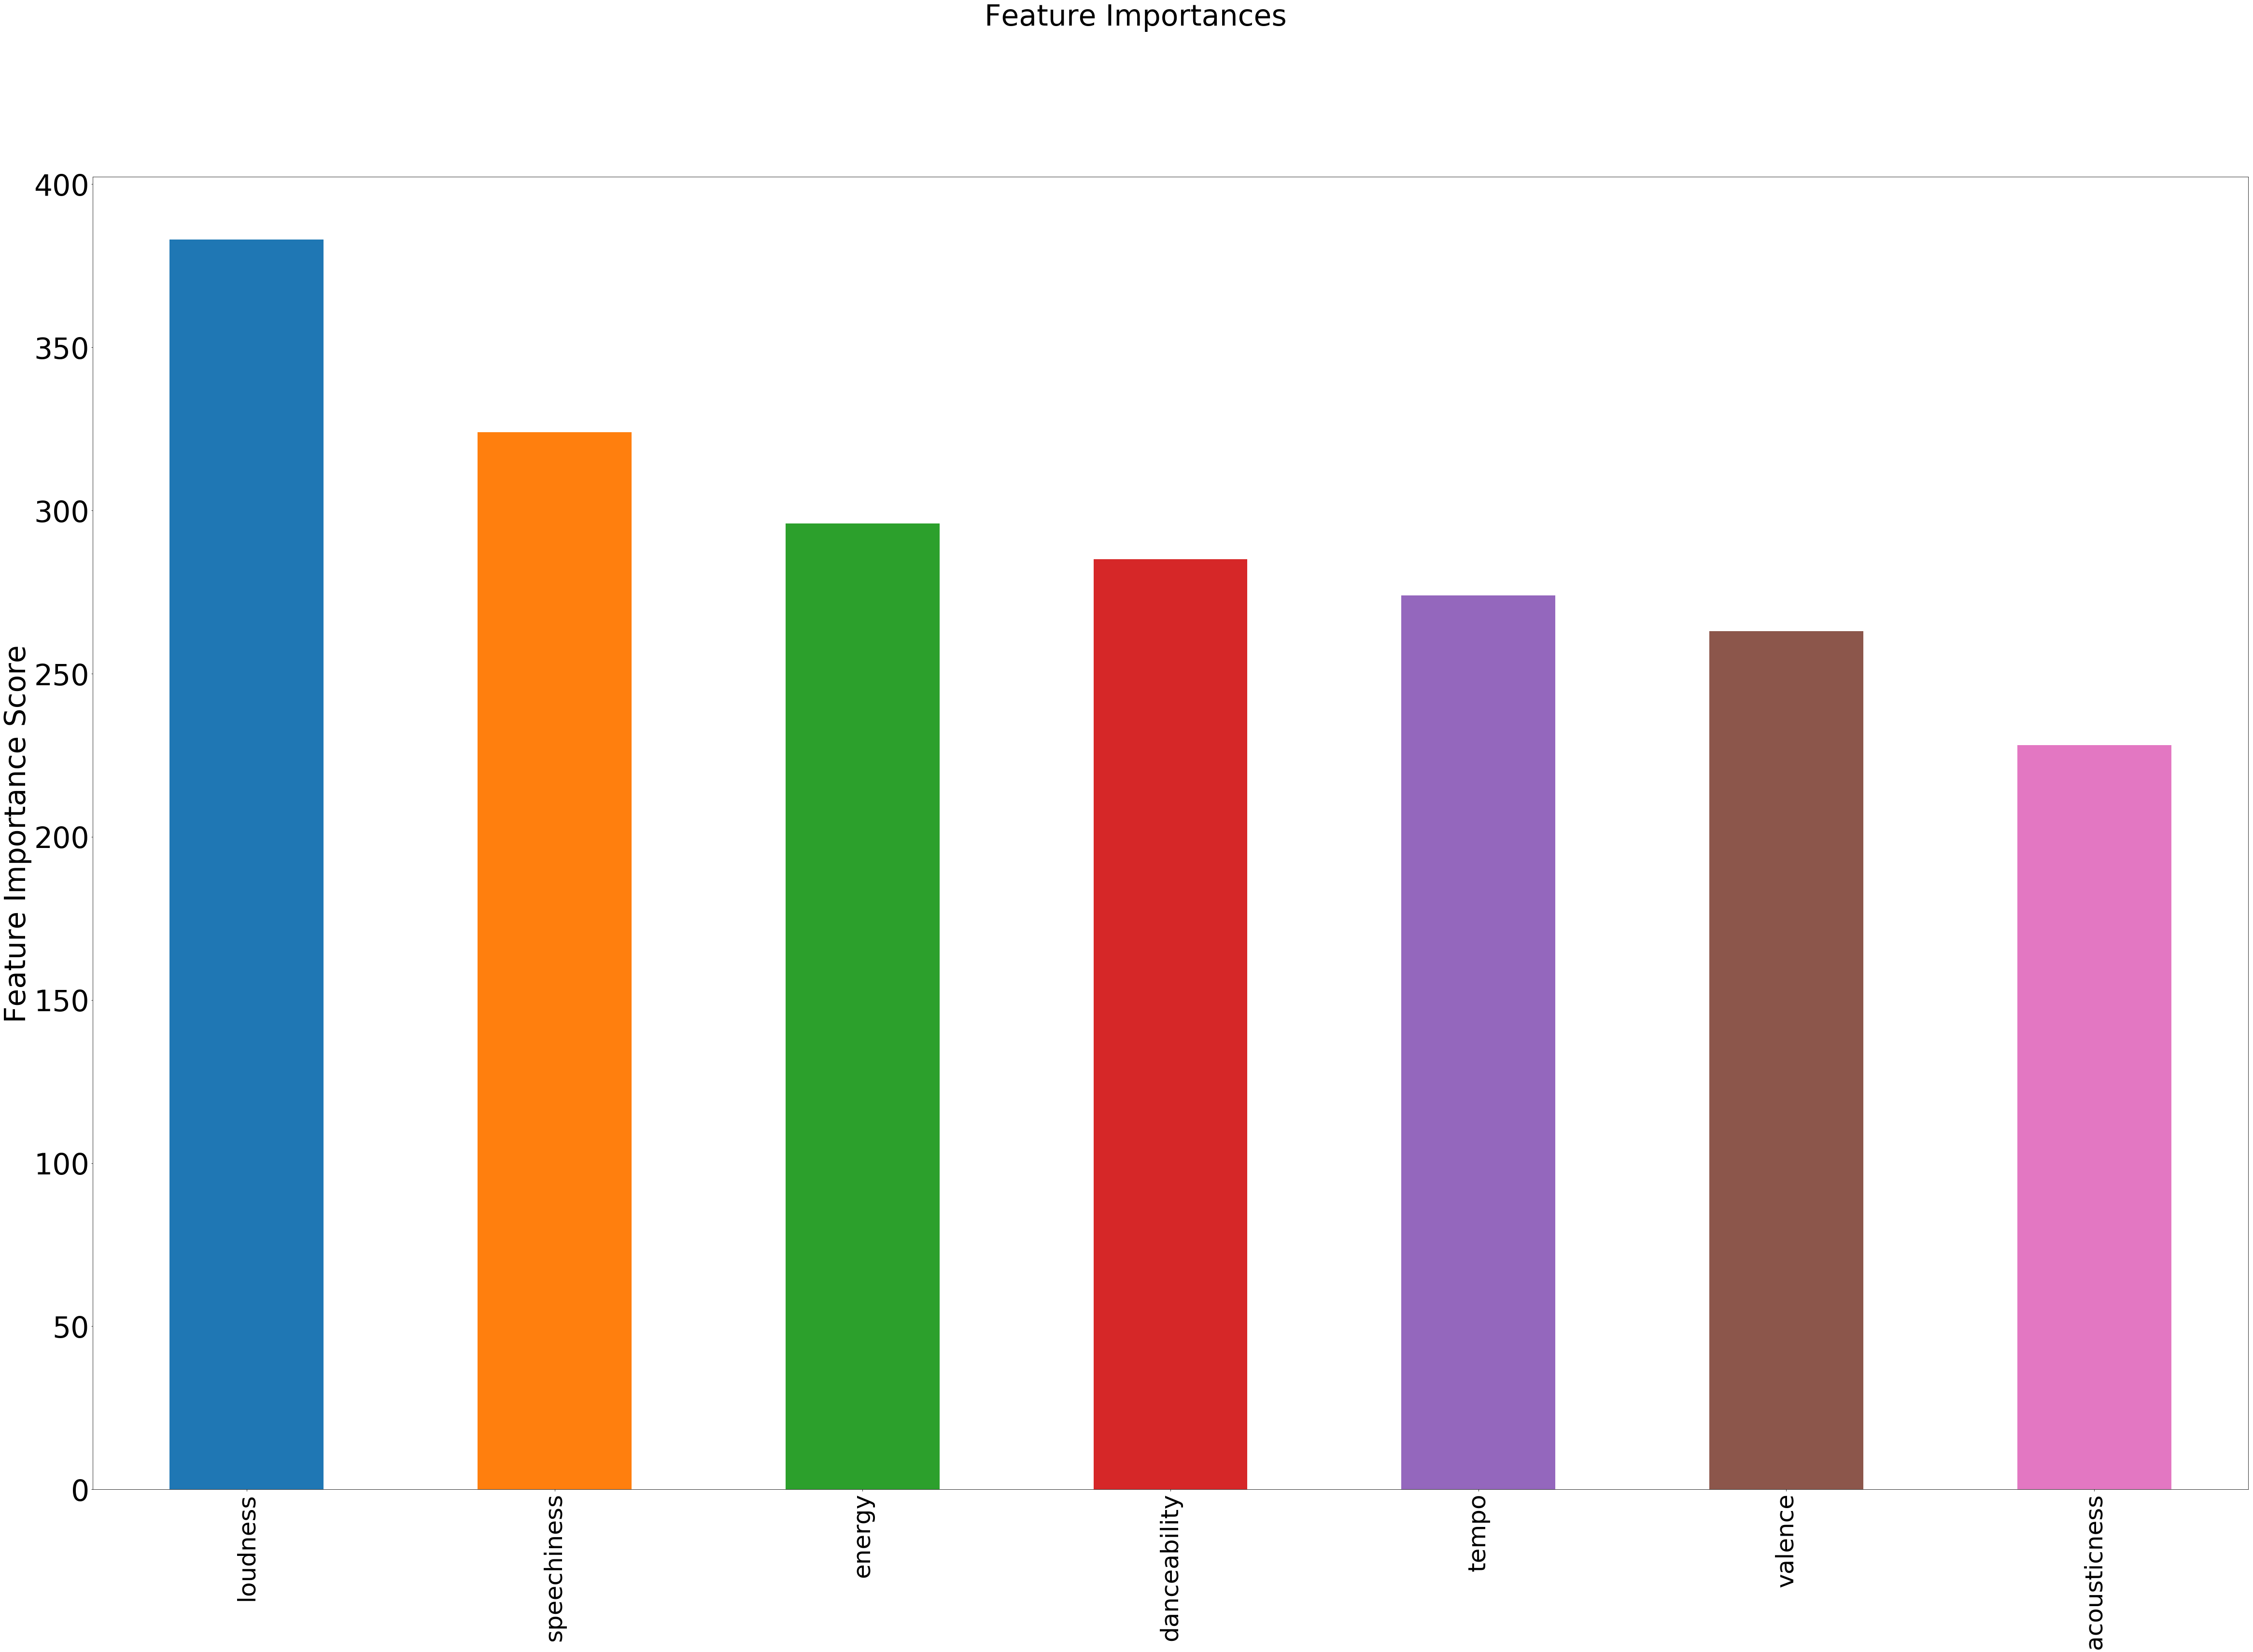

In [50]:
feat_imp = pd.Series(XGB.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.xticks(size = 50)
plt.yticks(size = 60)
plt.suptitle('Feature Importances', fontsize=60)
plt.ylabel('Feature Importance Score', size = 60)
plt.savefig("FE.eps")